In [13]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
from chaney_utils import (
    gen_social_network, 
    mu_sigma_to_alpha_beta, 
    exclude_new_items, 
    perfect_scores,
    interleave_new_items,
    process_measurement,
    MeanDistanceSimUsers,
    MeanInteractionDistance,
    SimilarUserInteractionSimilarity,
    InteractionTracker,
    RandomRecommender,
    ChaneyContent,
    IdealRecommender
)
from creator_sim import (
    ChaneyCreators,
    ideal_content_score_fns,
)
import warnings
warnings.simplefilter("ignore")

In [14]:
from creator_sim import (
    run_ideal_sim,
    run_content_sim,
    run_mf_sim,
    run_sf_sim,
    run_pop_sim,
    run_random_sim
)

In [15]:
# define constants
SEED = 1234
GENERATOR = np.random.default_rng(SEED)
NUM_USERS = 100
NUM_CREATORS = 10 
ITEMS_PER_CREATOR = 1 # each creator produces 1 item per timestep
NUM_ATTRS = 20 
NUM_SIMS = 25
# parameters provided in paper 
MU_N = 0.98 
SIGMA = 1e-5
DEBUG = True # if True, figures will not be written to files

## Generate synthetic data

In [16]:
user_params = GENERATOR.dirichlet(np.ones(NUM_ATTRS), size=NUM_SIMS) * 10

# each element in users is the users vector in one simulation
users, creators, social_networks = [], [], []
for sim_index in range(NUM_SIMS):
    # generate user preferences and item attributes
    user_prefs = GENERATOR.dirichlet(user_params[sim_index, :], size=NUM_USERS) # 100 users
    creator_attrs = GENERATOR.dirichlet(np.ones(NUM_ATTRS) * 10, size=NUM_CREATORS)
    
    # add all synthetic data to list
    users.append(user_prefs) 
    social_networks.append(gen_social_network(user_prefs))
    creators.append(creator_attrs) 


# Experiments

In [17]:
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
rep_train_results = {"mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
rep_train_models = {}

# stores results for each type of model for each type of user pairing (random or cosine similarity)
single_train_results = {"mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
single_train_models = {}

# mostly for plotting
id_to_readable = {
    "ideal": "ideal", 
    "content_chaney": "content filtering",
    "mf" : "matrix factorization",
    "sf": "social filtering",
    "popularity": "popularity", 
    "random": "random"
}

## Repeated training

In [37]:
sim_args = {
    "startup_iters": 10,
    "sim_iters": 90,
    "repeated_training": True,
    "new_items_per_iter": 10,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_attrs": NUM_ATTRS,
    "num_creators": NUM_CREATORS,
    "items_per_creator": ITEMS_PER_CREATOR,
    "sigma": SIGMA,
    "mu_n": MU_N,
    "learning_rate": 0.0005,
}

In [38]:
for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    creator_profiles = creators[i]
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    rep_train_models["ideal"] = run_ideal_sim(true_prefs, creator_profiles, pairs, sim_args, GENERATOR)
    ideal_interactions = np.hstack(process_measurement(rep_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    ideal_attrs = rep_train_models["ideal"].actual_item_attributes
    rep_train_models["content_chaney"] = run_content_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["mf"] = run_mf_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["sf"] = run_sf_sim(social_network, true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["popularity"] = run_pop_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    rep_train_models["random"] = run_random_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    
    # extract results from each model
    for model_key in model_keys:
        model = rep_train_models[model_key]
        rep_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            rep_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


In [19]:
# for plotting purposes
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})
smooth_sigma = 1.0

In [18]:
def graph_relative_to_ideal(train_results, metric_key, model_keys, label_map, absolute_measure=True, smooth_sigma=1):
    relative_dist = {}
    
    if absolute_measure:
        ideal_dist = np.array(train_results[metric_key]["ideal"])
    else:
        model_key = list(train_results[metric_key].keys())[0]
        # zeros for all timsteps
        timesteps = len(train_results[metric_key][model_key][0])
        ideal_dist = np.zeros(timesteps)
        relative_dist["ideal"] = ideal_dist

    for model_key in model_keys:
        if model_key is "ideal" and not absolute_measure:
            continue
            
        abs_dist = np.array(train_results[metric_key][model_key])
        if absolute_measure:
            abs_dist = abs_dist - ideal_dist
        relative_dist[model_key] = abs_dist.mean(axis=0) # average across 10 trials
        
    for m in model_keys:
        plt.plot(gaussian_filter1d(relative_dist[m], sigma=smooth_sigma), label=label_map[m])
    plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))

### Average distance between mean items

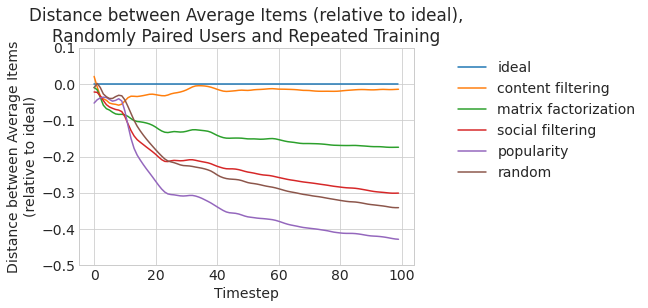

In [48]:
graph_relative_to_ideal(rep_train_results, "mean_item_dist", model_keys, id_to_readable)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/creator_repeated_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

### Change in Mean Item Distance (similar users paired)

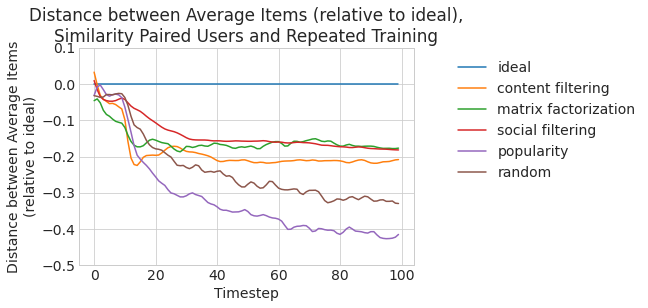

In [51]:
graph_relative_to_ideal(rep_train_results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nSimilarity Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/creator_repeated_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

## Single training

In [52]:
sim_args = {
    "startup_iters": 50,
    "sim_iters": 50,
    "repeated_training": False,
    "new_items_per_iter": 10,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_attrs": NUM_ATTRS,
    "num_creators": NUM_CREATORS,
    "items_per_creator": ITEMS_PER_CREATOR,
    "sigma": SIGMA,
    "mu_n": MU_N,
    "learning_rate": 0.0005,
}


In [53]:
for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    creator_profiles = creators[i]
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    single_train_models["ideal"] = run_ideal_sim(true_prefs, creator_profiles, pairs, sim_args, GENERATOR)
    ideal_interactions = np.hstack(process_measurement(single_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    ideal_attrs = single_train_models["ideal"].actual_item_attributes
    single_train_models["content_chaney"] = run_content_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["mf"] = run_mf_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["sf"] = run_sf_sim(social_network, true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["popularity"] = run_pop_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    single_train_models["random"] = run_random_sim(true_prefs, creator_profiles, pairs, ideal_interactions, ideal_attrs, sim_args, GENERATOR)
    
    # extract results from each model
    for model_key in model_keys:
        model = single_train_models[model_key]
        single_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            single_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


### Average distance between mean items

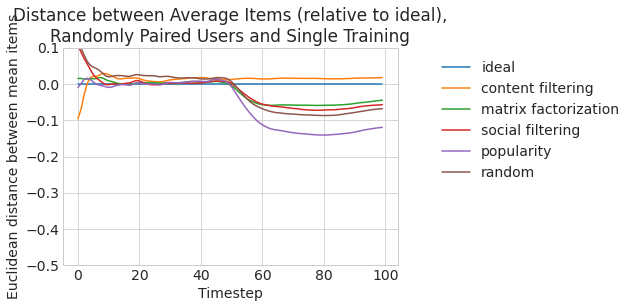

In [54]:
graph_relative_to_ideal(single_train_results, "mean_item_dist", model_keys, id_to_readable)

plt.ylabel("Euclidean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/creator_single_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

### Change in Mean Item Distance (similar users paired)

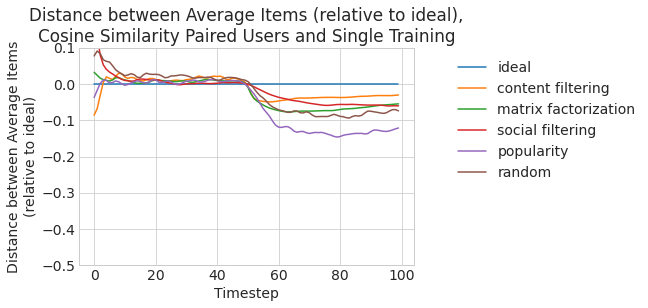

In [55]:
graph_relative_to_ideal(single_train_results, "sim_user_dist", model_keys, id_to_readable, absolute_measure=False)

plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/creator_single_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")